In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as sp_optimize
import patsy

from gradvi.inference import WaveletRegression
from gradvi.normal_means import NormalMeansFromPosterior
from gradvi.tests import toy_priors

In [2]:
def HaarMat(N):
    if N == 1: return np.array([[1]])
    H = 1/np.sqrt(2)*np.concatenate(
        (
            np.kron(HaarMat(N//2),[1,1])
        ,
            np.kron(np.identity(N//2),[1,-1])
        ),axis = 0
        )
    return H

def invHaarMat(N):
    return HaarMat(N).transpose()

In [3]:
import patsy

def get_sparse_signal(n, nknots = 4, degree = 2, include_intercept = False):
    
    def sample_sign(n, f = 0.5):
        return np.random.choice([-1, 1], size=n, p=[f, 1 - f])
    
    xlin = np.linspace(0, 1, n)
    knots = np.linspace(0, 1, nknots+2)[1:-1]
    bspline = patsy.bs(xlin, knots = knots, degree = degree, 
                       include_intercept = include_intercept)
    nbase = knots.shape[0] + degree + int(include_intercept)
    beta  = np.random.gamma(40, 0.1, size = nbase)
    beta *= sample_sign(nbase)
    ytrue = np.dot(bspline, beta)
    return ytrue

n = 2 ** 8
nc = 10
s2 = 0.2 # variance of error to be added to signal
xlin = np.linspace(0, 1, n)
np.random.seed(100)


xtrue = get_sparse_signal(n, nknots = 4, degree = 3)

# Create sparse signal
# xtrue = np.zeros(n)
# nc_idx = np.random.choice(n, nc, replace = False)
# xtrue[nc_idx] = np.random.normal(0, 2, size = nc)

# Haar matrices
W = HaarMat(n)
Winv = invHaarMat(n)

# True Wavelet coefficients
btrue  = np.dot(W, xtrue)

# Add some noise to signal
xsignal = xtrue + np.random.normal(0, 1, size = n) * np.sqrt(s2)

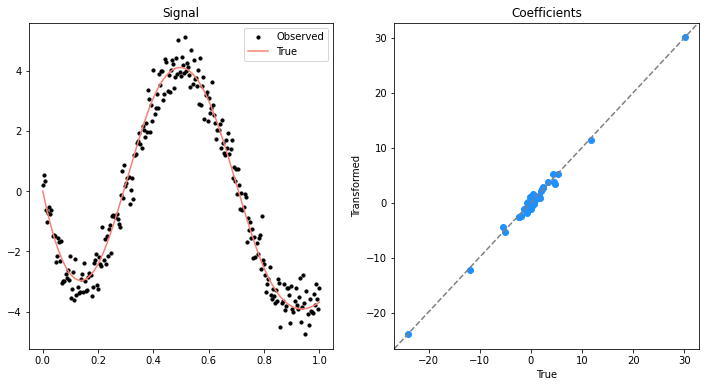

In [4]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(xlin, xsignal, label = "Observed", s = 10, color = 'black')
ax1.plot(xlin, xtrue, label = "True", color = 'salmon')
ax1.set_title("Signal")
ax1.legend()

# ax2.scatter(xlin, btrue, label = "True", color = 'black', s = 10)
# ax2.plot(xlin, np.dot(W, xsignal), label = "Transformed", color = 'salmon')
# ax2.set_title("Coefficients")
# ax2.legend()

ax2.scatter(btrue, np.dot(W, xsignal), color = 'dodgerblue')
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, ls = '--', color = 'gray')
ax2.set_title("Coefficients")
ax2.set_xlabel("True")
ax2.set_ylabel("Transformed")

plt.show()

In [5]:
prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = 10)
gv = WaveletRegression(debug = False, display_progress = False, optimize_s = False)
gv.fit(xsignal, prior, W, s2_init = s2)

2022-04-25 17:45:21,049 | gradvi.inference.wavelet_regression | INFO | Terminated at iteration   71.


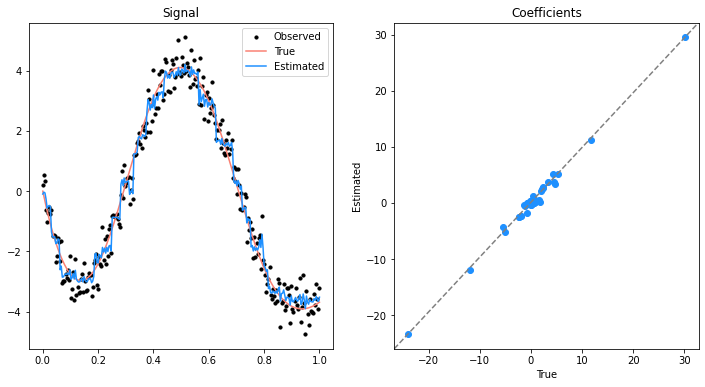

In [6]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(xlin, xsignal, label = "Observed", s = 10, color = 'black')
ax1.plot(xlin, xtrue, label = "True", color = 'salmon')
ax1.plot(xlin, gv._res.signal, label = "Estimated", color = 'dodgerblue')
ax1.set_title("Signal")
ax1.legend()

#ax2.scatter(xlin, btrue, label = "True", color = 'black', s = 10)
ax2.scatter(btrue, gv.coef, color = 'dodgerblue')
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, ls = '--', color = 'gray')
ax2.set_title("Coefficients")
ax2.set_xlabel("True")
ax2.set_ylabel("Estimated")

plt.show()